In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import easyocr
from colorama import Fore

from ultralytics import YOLO
from imutils.perspective import four_point_transform

ModuleNotFoundError: No module named 'easyocr'

In [2]:
def detect_license_plate(model, img_path, pad=0.4, conf=0.45, imgsz=1280):
    results = model.predict(img_path, save=False, imgsz=imgsz, verbose=False, conf=conf, max_det=1)

    if len(results[0].boxes.cls) == 0:
        return None
    img = cv2.imread(img_path)
    x1, y1, x2, y2 = results[0].boxes[0].xyxy[0]

    if pad is not None:
        pad_x = int((x2 - x1) * pad)
        pad_y = int((y2 - y1) * pad)
        x1 = max(0, int(x1 - pad_x))
        y1 = max(0, int(y1 - pad_y))
        x2 = min(img.shape[1], int(x2 + pad_x))
        y2 = min(img.shape[0], int(y2 + pad_y))

    return img[int(y1):int(y2), int(x1):int(x2), :]

In [3]:
def get_folder_images(folder_path):

    images = glob.glob(folder_path + '/*.jpg') + \
              glob.glob(folder_path + '/*.JPG') + \
              glob.glob(folder_path + '/*.jpeg') + \
              glob.glob(folder_path + '/*.png') + \
              glob.glob(folder_path + '/*.bmp')

    return images

def get_text_from_image(reader, img, min_size=10):

    extracted_text = reader.readtext(img,
                                    allowlist='0123456789',
                                    detail=0,
                                    paragraph=True,
                                    min_size=min_size,
                                    )
    return extracted_text

def fix_perspective(reader, img):
    _, free_list = reader.detect(img, text_threshold=0.1)

    images = []
    if len(free_list[0]) != 0:
        for i in range(len(free_list[0])):
                a, b, c, d = free_list[0][i]
                points = np.array([a, b, c, d], np.int32).reshape((-1, 1, 2))
                warped = four_point_transform(img, points.reshape(4,2))
                images.append(warped)
        return images
    else:
      return None

In [4]:
# this functions processes all images in a folder and returns the possible license plates
def process_folder(folder_path, model_path, pad=0.4):

    model = YOLO(model_path, verbose=False)
    reader = easyocr.Reader(['en'], verbose=False)

    images = get_folder_images(folder_path)

    results = []
    for image in images:
        cropped_img = detect_license_plate(model, image, pad=0.4, imgsz=1280, conf=0.77)
        if cropped_img is None:
            continue

        # perform OCR
        extracted_text = get_text_from_image(reader, cropped_img)
        results.append(extracted_text)
        print(Fore.GREEN + 'TEXT EXTRACTED')
        print(extracted_text)
        plt.imshow(cropped_img)
        plt.show()
    return results

TEXT EXTRACTED
['7 79562']


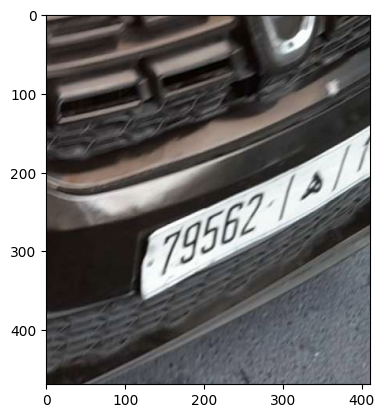

TEXT EXTRACTED
['9362']


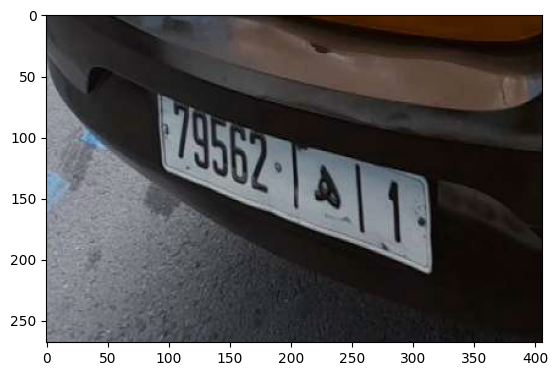

TEXT EXTRACTED
['7460 4']


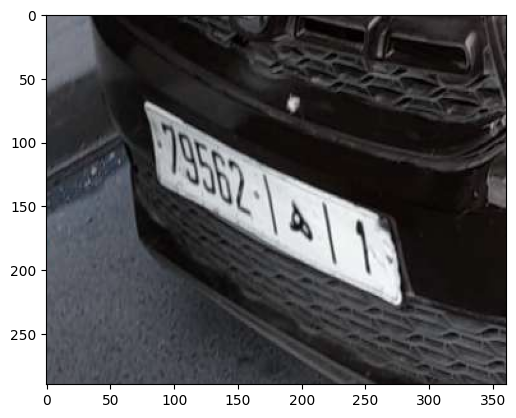

TEXT EXTRACTED
['795626 41']


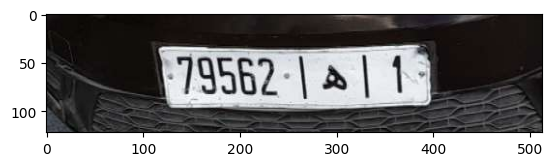

TEXT EXTRACTED
['76 4']


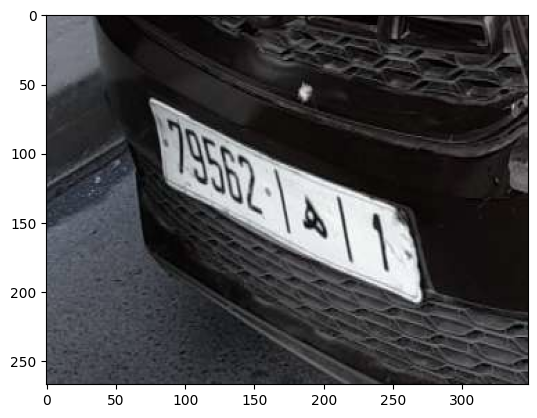

TEXT EXTRACTED
['013624']


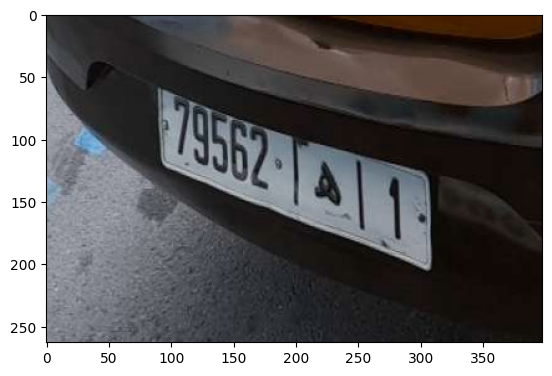

TEXT EXTRACTED
['9']


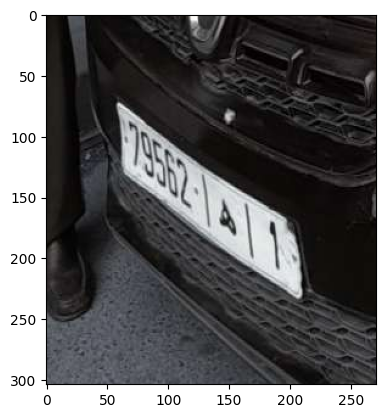

TEXT EXTRACTED
['7 79562']


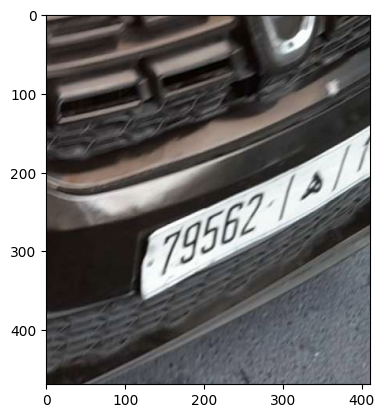

TEXT EXTRACTED
['9362']


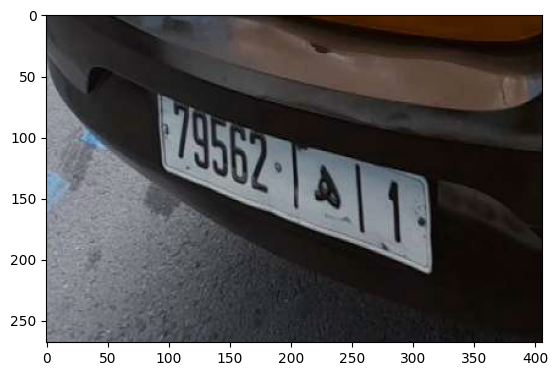

TEXT EXTRACTED
['7460 4']


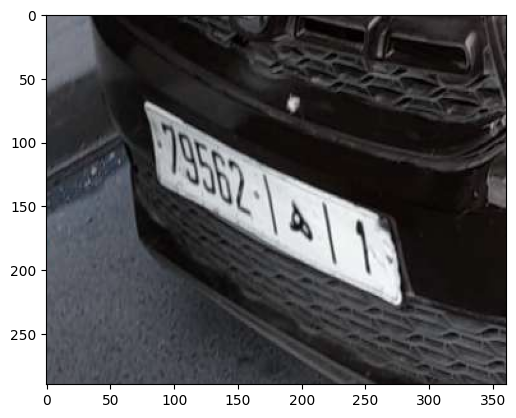

TEXT EXTRACTED
['795626 41']


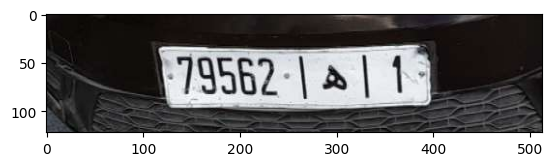

TEXT EXTRACTED
['76 4']


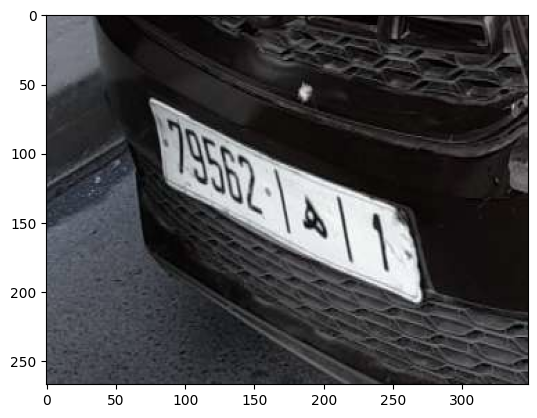

TEXT EXTRACTED
['013624']


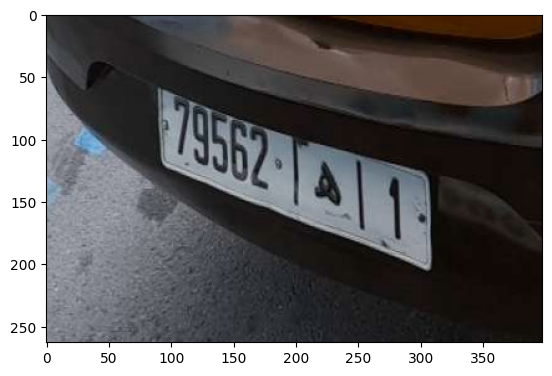

TEXT EXTRACTED
['9']


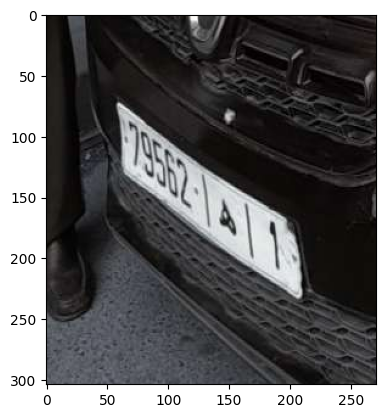

In [13]:
results = process_folder(folder_path='./data/2024000118', 
                         model_path='./best.pt')

In [14]:
results

[['7 79562'],
 ['9362'],
 ['7460 4'],
 ['795626 41'],
 ['76 4'],
 ['013624'],
 ['9'],
 ['7 79562'],
 ['9362'],
 ['7460 4'],
 ['795626 41'],
 ['76 4'],
 ['013624'],
 ['9']]

In [15]:
# reorder big first
def process_results(results):
    processed = []
    for result in results:
        if len(result) > 2:
            continue
        if len(result) == 1:
            result = result[0].split()
        result = sorted(result, key=len, reverse=True)
        result = ''.join(result)
        if len(result) > 4:
            processed.append(result)
    return processed

In [16]:
res = process_results(results)

In [17]:
res

['795627',
 '74604',
 '79562641',
 '013624',
 '795627',
 '74604',
 '79562641',
 '013624']

In [18]:
from difflib import SequenceMatcher

def extract_occurences(results):
    substring_counts={}

    for i in range(0, len(results)):
        for j in range(i+1,len(results)):
            string1 = results[i]
            string2 = results[j]
            match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))
            matching_substring=string1[match.a:match.a+match.size]
            if(matching_substring not in substring_counts):
                substring_counts[matching_substring]=1
            else:
                substring_counts[matching_substring]+=1
    # remove unwanted substrings
    for k in list(substring_counts.keys()):
        print(k)
        if len(k) < 5 or len(k) > 14:
            del substring_counts[k]

    return substring_counts

In [19]:
if len(res) > 1:
    possible_license_plate = extract_occurences(res)
else:
    possible_license_plate = res

7
79562
62
795627
4
74604
79562641
0
013624


In [20]:
possible_license_plate

{'79562': 4, '795627': 1, '74604': 1, '79562641': 1, '013624': 1}

In [21]:
def pick_top(substring_counts, k=1):
    return sorted(substring_counts, key=lambda x: substring_counts[x], reverse=True)[:k]

In [22]:
pick_top(possible_license_plate)

['79562']

In [1]:
# import textdistance as td

# text1 = '40731'
# text2 = '63271'

# td.levenshtein(text1, text2)
# td.damerau_levenshtein.normalized_similarity(text1, text2)
# td.jaro(text1, text2)